In [1]:
!pip install matplotlib tqdm

In [2]:
import argparse
from pathlib import Path
import multiprocessing
from time import time
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm import tqdm

# self-written modules
from helpers import (
    pie_plot_categories, Feasibility, calculate_success_rate, plot_success_rate,
    plot_feasibility_ratio_by_tasks, plot_success_rate_by_tasks,
    plot_feasibility_ratio_by_utilization, plot_success_rate_by_utilization
)
from algorithms import RateMonotonic, DeadlineMonotonic, Audsley, EarliestDeadlineFirst, RoundRobin
from parse_tasks import parse_task_file
from main import review_task_sets_in_parallel

In [3]:
# Calculate feasibility ratio by parameter
def calculate_feasibility_ratio(schedule_stats):
    feasible = schedule_stats.get(Feasibility.FEASIBLE_SHORTCUT, 0) + \
               schedule_stats.get(Feasibility.FEASIBLE_SIMULATION, 0)
    total = feasible + schedule_stats.get(Feasibility.NOT_SCHEDULABLE_BY_A_SHORTCUT, 0) + \
            schedule_stats.get(Feasibility.NOT_SCHEDULABLE_BY_A_SIMULATION, 0)
    if total == 0:
        return 0
    return feasible / total * 1.0

In [4]:
# process task sets for Plot 1 and 2 (by number of tasks)
def process_by_tasks(algorithms, folder_name, verbose, force_simulation):
    """
    Process task sets organized by number of tasks (e.g., in 80-percent/).

    Returns:
    - feasibility_ratios: dict with number of tasks as keys and feasibility ratios as values.
    - success_rates: dict with algorithm names as keys and dicts of task numbers to success rates as values.
    """
    subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name.split('-')[0]))
    feasibility_ratios = {}
    success_rates = {alg.upper(): {} for alg in algorithms}

    for subfolder in subfolders:
        num_tasks = int(subfolder.name.split('-')[0])  # e.g., '10-tasks/' -> 10
        print(f"\nProcessing {num_tasks} tasks in {subfolder}")

        # Calculate feasibility ratio using optimal scheduler (EDF)
        schedule_stats_optimal = review_task_sets_in_parallel("edf", subfolder, verbose, force_simulation)
        feasible_ratio = calculate_feasibility_ratio(schedule_stats_optimal)
        feasibility_ratios[num_tasks] = feasible_ratio

        # Now, calculate success rates for each algorithm
        for alg in algorithms:
            print(f"Evaluating algorithm: {alg}")
            schedule_stats = review_task_sets_in_parallel(alg, subfolder, verbose, force_simulation)
            success_rate = calculate_success_rate(schedule_stats)
            success_rates[alg.upper()][num_tasks] = success_rate

    return feasibility_ratios, success_rates

In [5]:
# process task sets for Plot 3 and 4 (by utilization)
def process_by_utilization(algorithms, folder_name, verbose, force_simulation):
    """
    Process task sets organized by utilization (e.g., in 10-tasks/).

    Returns:
    - feasibility_ratios: dict with utilization levels as keys and feasibility ratios as values.
    - success_rates: dict with algorithm names as keys and dicts of utilizations to success rates as values.
    """
    subfolders = sorted([f for f in Path(folder_name).iterdir() if f.is_dir()], key=lambda x: int(x.name.split('-')[0]))
    feasibility_ratios = {}
    success_rates = {alg.upper(): {} for alg in algorithms}

    for subfolder in subfolders:
        utilization = int(subfolder.name.split('-')[0])  # e.g., '10-percent/' -> 10
        print(f"\nProcessing {utilization}% utilization in {subfolder}")

        # Calculate feasibility ratio using optimal scheduler (EDF)
        schedule_stats_optimal = review_task_sets_in_parallel("edf", subfolder, verbose, force_simulation)
        feasible_ratio = calculate_feasibility_ratio(schedule_stats_optimal)
        feasibility_ratios[utilization] = feasible_ratio

        # Now, calculate success rates for each algorithm
        for alg in algorithms:
            print(f"Evaluating algorithm: {alg}")
            schedule_stats = review_task_sets_in_parallel(alg, subfolder, verbose, force_simulation)
            success_rate = calculate_success_rate(schedule_stats)
            success_rates[alg.upper()][utilization] = success_rate

    return feasibility_ratios, success_rates


In [6]:
# Main function to do the analysis
def analyze_scheduling_algorithms(algorithms, task_set_type, verbose=False, force_simulation=False):
    start_time = time()

    if task_set_type == 'by_tasks':
        folder_name = "tasksets/80-percent/"
        feasibility_ratios, success_rates = process_by_tasks(algorithms, folder_name, verbose, force_simulation)

        # Plot 1: Ratio of task sets that are feasible according to the number of tasks
        plot_feasibility_ratio_by_tasks(
            feasibility_ratios,
            utilization=80,
            plot_title="Feasibility Ratio by Number of Tasks at 80% Utilization"
        )

        # Plot 2: Success rate of each algorithm according to the number of tasks
        plot_success_rate_by_tasks(
            success_rates,
            utilization=80,
            plot_title="Success Rate by Number of Tasks at 80% Utilization"
        )

    elif task_set_type == 'by_utilization':
        folder_name = "tasksets/10-tasks/"
        feasibility_ratios, success_rates = process_by_utilization(algorithms, folder_name, verbose, force_simulation)

        # Plot 3: Ratio of task sets that are feasible according to the utilization
        plot_feasibility_ratio_by_utilization(
            feasibility_ratios,
            num_tasks=10,
            plot_title="Feasibility Ratio by Utilization for 10 Tasks"
        )

        # Plot 4: Success rate of each algorithm according to the utilization
        plot_success_rate_by_utilization(
            success_rates,
            num_tasks=10,
            plot_title="Success Rate by Utilization for 10 Tasks"
        )

    print(f"\nTime taken: {int(time() - start_time)} seconds")



Processing 10% utilization in tasksets/10-tasks/10-percent
Total files considered: 500 out of 500
Evaluating algorithm: dm
Total files considered: 500 out of 500
Evaluating algorithm: edf
Total files considered: 500 out of 500
Evaluating algorithm: rr
Total files considered: 500 out of 500

Processing 20% utilization in tasksets/10-tasks/20-percent
Total files considered: 500 out of 500
Evaluating algorithm: dm
Total files considered: 500 out of 500
Evaluating algorithm: edf
Total files considered: 500 out of 500
Evaluating algorithm: rr
Total files considered: 500 out of 500

Processing 30% utilization in tasksets/10-tasks/30-percent
Total files considered: 500 out of 500
Evaluating algorithm: dm
Total files considered: 500 out of 500
Evaluating algorithm: edf
Total files considered: 500 out of 500
Evaluating algorithm: rr
Total files considered: 500 out of 500

Processing 40% utilization in tasksets/10-tasks/40-percent
Total files considered: 500 out of 500
Evaluating algorithm: dm


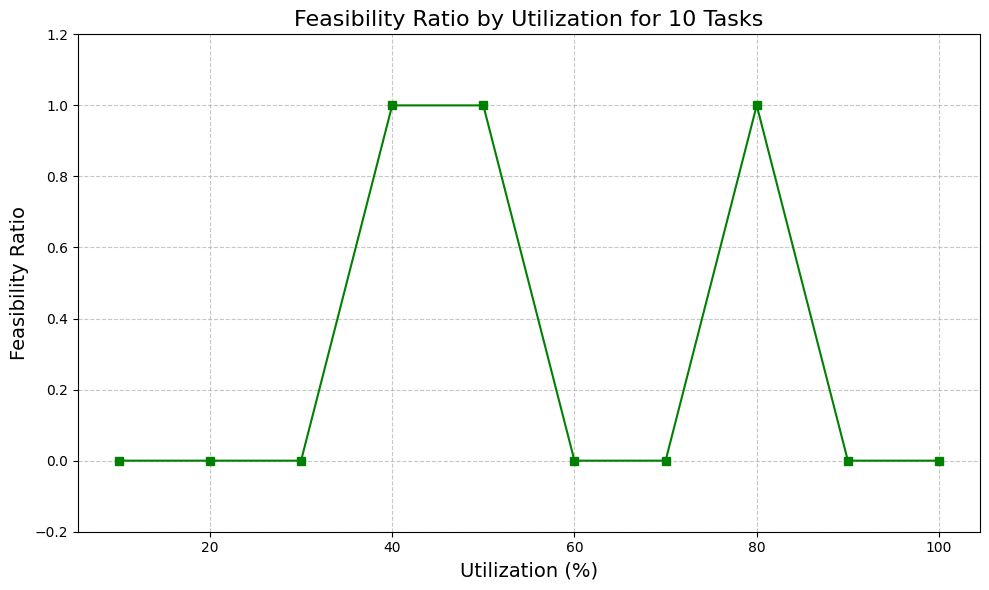

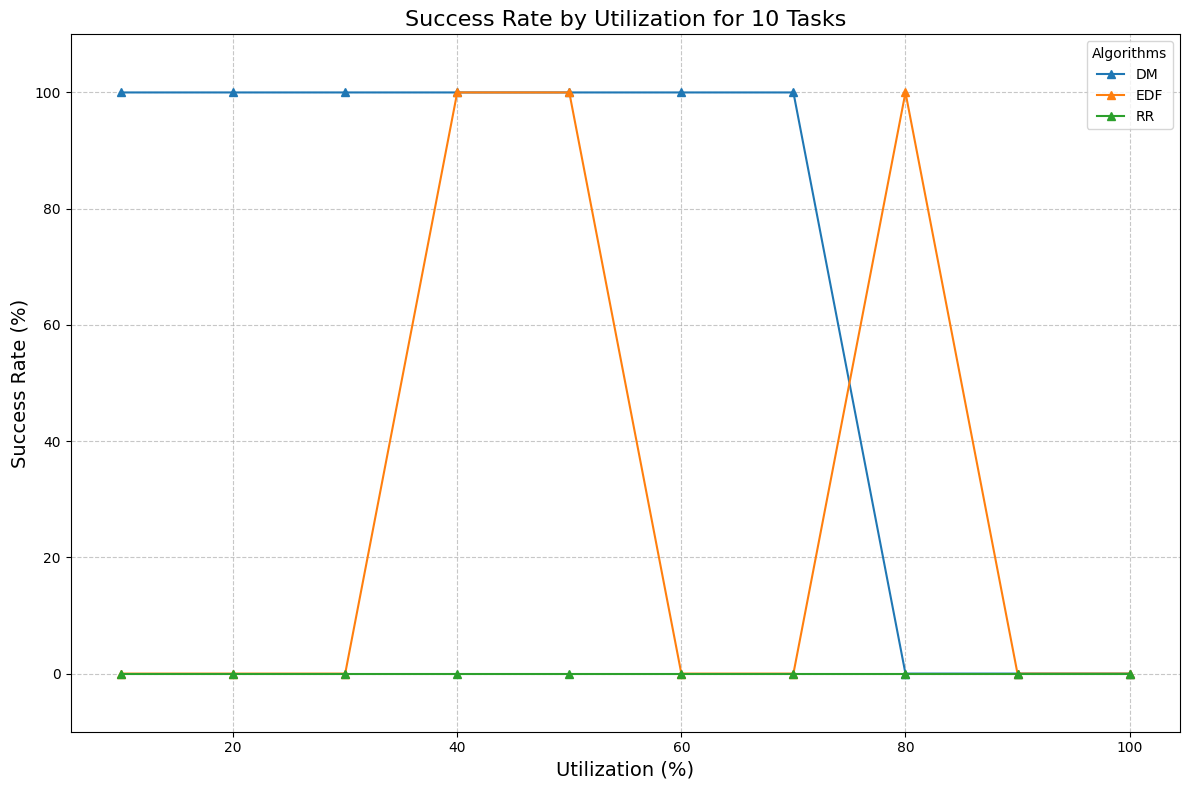


Time taken: 4 seconds


In [8]:
# algorithms_to_evaluate = ['rm', 'dm', 'audsley', 'edf', 'rr']
algorithms_to_evaluate = ['dm', 'edf', 'rr']

# 'by_tasks' or 'by_utilization'
task_set_type_choice = 'by_utilization'
#task_set_type_choice = 'by_tasks'

analyze_scheduling_algorithms(
    algorithms=algorithms_to_evaluate,
    task_set_type=task_set_type_choice,
    verbose=False,
    force_simulation=False
)